<a href="https://colab.research.google.com/github/ChaaruVijay/DSPL-CourseWork/blob/main/LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
import pandas as pd
import numpy as np

In [82]:
# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/Data Science/cleaned_traincsv (3).csv")

In [83]:
# Drop Customer_ID (not useful for prediction)
df_cleaned = df.drop(columns=['Customer_ID'])

In [84]:
# Define features and target
X = df_cleaned.drop(columns=['cluster_catgeory'])  # Features
y = df_cleaned['cluster_catgeory']  # Target variable

In [85]:
#check that the list of input variables
list(X)

['outlet_city', 'luxury_sales', 'fresh_sales', 'dry_sales']

In [86]:
#check that the list of target variable
y.head()

,cluster_catgeory
0,4.0
1,1.0
2,4.0
3,4.0
4,4.0


In [87]:
# Before creating LightGBM datasets, ensure labels are in the correct range
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit the encoder to the target variable and transform it
y_encoded = label_encoder.fit_transform(y)

# Now use the encoded target variable for splitting and creating LightGBM datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=14, stratify=y_encoded)


#This is to show the number of instances and input features in the training and test sets
print('X_train Instances', X_train.shape)
print('X_test Instances', X_test.shape)


X_train Instances (619226, 4)
X_test Instances (154807, 4)


In [88]:
from imblearn.over_sampling import SMOTE
# For handling imbalanced data
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [89]:
# Create LightGBM dataset format
import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [90]:
import lightgbm as lgb

# Optimized parameters
params = {
    "objective": "multiclass",
    "num_class": len(np.unique(y)),
    "metric": "multi_logloss",
    "boosting_type": "dart",
    "learning_rate": 0.03,
    "class_weight" : "balanced",
    "num_leaves": 10,
    "max_depth": 3,
    "min_data_in_leaf": 50,
    "feature_fraction": 0.5,
    "bagging_fraction": 0.5,
    "bagging_freq": 3,
    "lambda_l1": 0.1,
    "lambda_l2": 0.1,
    "num_threads": 4,
    "device": "cpu",
    "early_stopping_rounds": 50
}

In [91]:
num_boost_round = 150  # Number of trees

# Train LightGBM with early stopping
model = lgb.train(
    params,
    train_data,
    valid_sets=[test_data],
    num_boost_round=num_boost_round,
    callbacks=[lgb.early_stopping(50, verbose=False)]
)

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 906990, number of used features: 4
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

/usr/local/lib/python3.11/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [92]:
 #Make predictions
y_pred = model.predict(X_test)
y_pred_classes = [np.argmax(line) for line in y_pred]  # Convert probability output to class

In [93]:
# Evaluate model performance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred_classes))

Accuracy: 0.9136
              precision    recall  f1-score   support

           0       0.99      0.91      0.95     37791
           1       0.87      0.97      0.91     31007
           2       0.86      0.71      0.78      9778
           3       0.90      0.99      0.95     34485
           4       0.71      0.86      0.78      7905
           5       0.97      0.86      0.91     33841

    accuracy                           0.91    154807
   macro avg       0.88      0.88      0.88    154807
weighted avg       0.92      0.91      0.91    154807



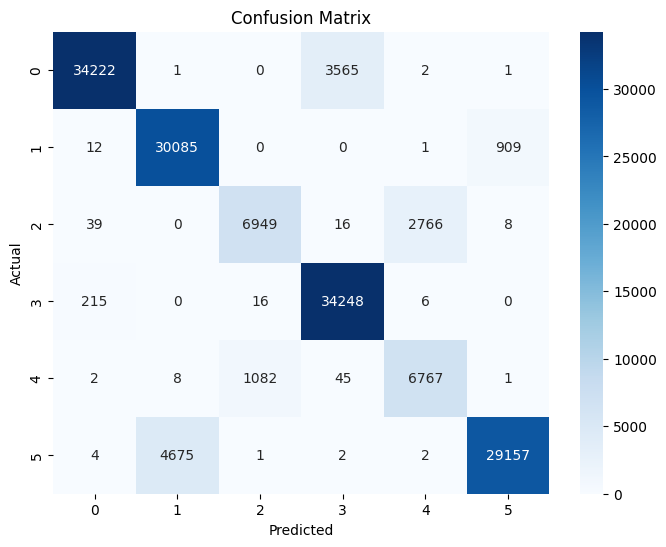

In [94]:
# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_classes), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

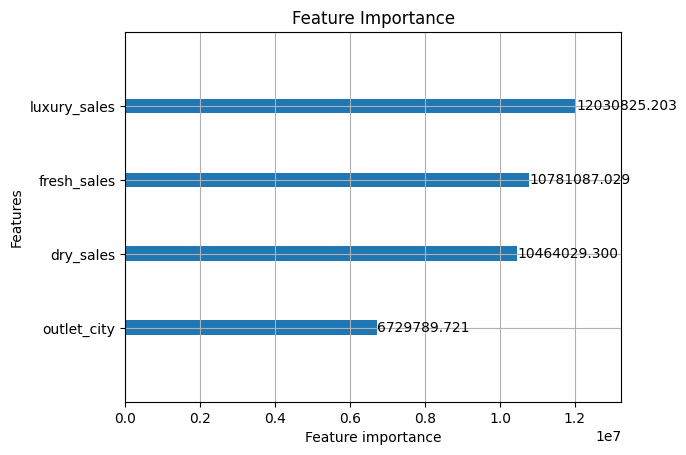

In [95]:
# Feature importance visualization
lgb.plot_importance(model, max_num_features=10, importance_type="gain")
plt.title("Feature Importance")
plt.show()

In [99]:
!pip install --upgrade lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 32.1 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.5.0
    Uninstalling lightgbm-4.5.0:
      Successfully uninstalled lightgbm-4.5.0


[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 906990, number of used features: 4
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

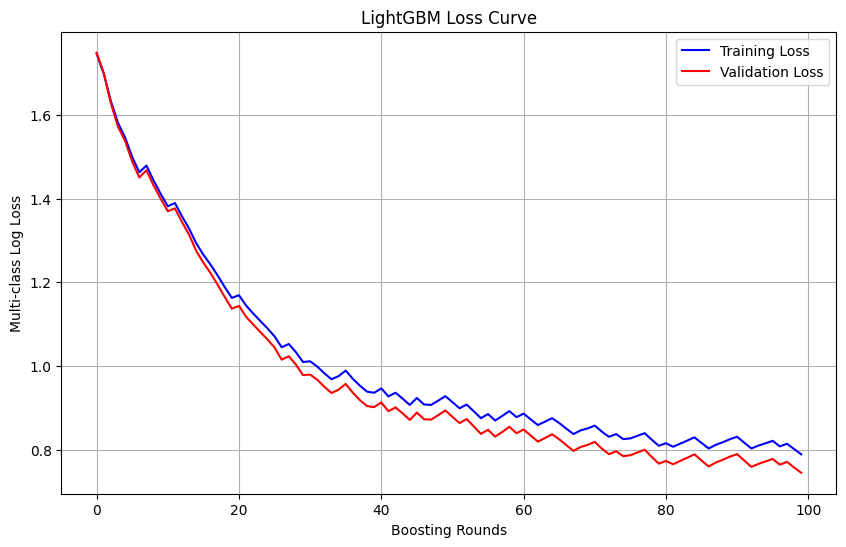

In [102]:
import lightgbm as lgb

# Dictionary to store training history
evals_result = {}

import warnings
warnings.filterwarnings("ignore")

# Train LightGBM model and log loss values
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],  # Monitor both training & validation loss
    valid_names=["Train", "Validation"],
    num_boost_round=100,
    # 'early_stopping_rounds' is moved to the callbacks list
    callbacks=[lgb.early_stopping(20, verbose=True), lgb.record_evaluation(evals_result)],
)

# Extract loss values
train_loss = evals_result["Train"]["multi_logloss"]
val_loss = evals_result["Validation"]["multi_logloss"]
epochs = range(len(train_loss))

# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label="Training Loss", color="blue")
plt.plot(epochs, val_loss, label="Validation Loss", color="red")
plt.xlabel("Boosting Rounds")
plt.ylabel("Multi-class Log Loss")
plt.title("LightGBM Loss Curve")
plt.legend()
plt.grid(True)
plt.show()